### **Projet de réassurance 2024**  
**Calibrage d'un programme en Top & Drop**  
*Louis Bolzinger*  
*Paul Noiret*


#### **Importation**

In [ ]:
#pip install pyextremes

In [164]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go 
px.defaults.template = "plotly_white"
px.defaults.width = 800
px.defaults.height = 400

from functools import reduce
import warnings
warnings.filterwarnings("ignore")

import numpy as np



In [2]:
df = pd.read_csv("fire_denmark.csv")

# Convertir la colonne "Date" en datetime
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month


#https://donnees.banquemondiale.org/indicateur/NY.GDP.DEFL.KD.ZG?locations=DK  source indice inflation
dfi = pd.read_csv("inflation.csv")
dfi = dfi.T
nouvelles_colonnes = dfi.iloc[0]
dfi = dfi[1:]
dfi.columns = nouvelles_colonnes
dfi = dfi.reset_index()
dfi = dfi.rename(columns={'index': 'Année'}).loc[21:31]
dfi['Année'] = dfi['Année'] .astype(int)


#### **Question 1** Faire  quelques  statistiques  descriptives  et  tracés  pour  décrire  les  sinistres  dont  vous disposez. 

In [6]:

def generate_descriptive_plots(df, loss_column):
    # Statistiques descriptives
    stats_descriptives = df[loss_column].describe()
    print("Statistiques descriptives pour les sinistres :\n", stats_descriptives)

    # Histogramme de la distribution des sinistres
    histogram = px.histogram(df, x=loss_column, title="Distribution des sinistres")
    histogram.show()

    # Nombre de sinistres par année
    sinistres_par_annee = df.groupby('Year').size().reset_index(name='Nombre de sinistres')
    evolution_sinistres = px.line(sinistres_par_annee, x='Year', y='Nombre de sinistres',
                                   title="Évolution du nombre de sinistres par année")
    evolution_sinistres.show()

    # Évolution du coût moyen, maximum et minimum par année
    annee_stats = df.groupby('Year').agg({loss_column: ['mean', 'max', 'min']}).reset_index()
    annee_stats.columns = ['Year', 'Coût moyen', 'Coût maximum', 'Coût minimum']
    fig = px.line(annee_stats, x='Year', y=['Coût moyen', 'Coût maximum', 'Coût minimum'],
                  title="Évolution des coûts par année")
    fig.show()

    # Nombre moyen de sinistres par mois
    moyenne_sinistres_par_mois = df.groupby(['Year', 'Month']).size().groupby('Month').mean().reset_index(name='Nombre moyen de sinistres')
    fig = px.line(moyenne_sinistres_par_mois, x='Month', y='Nombre moyen de sinistres',
                  title="Nombre moyen de sinistres par mois")
    fig.show()


generate_descriptive_plots(df, 'LossY')


Statistiques descriptives pour les sinistres :
 count    2167.000000
mean        2.609839
std         6.226331
min         0.727080
25%         1.014092
50%         1.354302
75%         2.284627
max       141.732360
Name: LossY, dtype: float64


#### **Question 2** Revaloriser les sinistres à l’aide d’un indice d’inflation judicieusement choisi. Réalisez les mêmes statistiques descriptives que la question précédente sur les sinistres ajustés. Commenter. 

In [3]:
dfi['Indice_cumulatif'] = 0
inflation = dfi['Danemark'].tolist()

for i in range(dfi.shape[0]):
    liste = inflation[:i+1]
    liste = [x/100 + 1 for x in liste]
    dfi.iloc[i, -1] = reduce(lambda x, y: x * y, liste) - 1

In [7]:
df['Loss As IF 1980'] = 0

for i in range(df.shape[0]):
    if df.loc[i, 'Year'] == 1980 : inflation = 0
    else : inflation = dfi.loc[dfi['Année'] == df.loc[i, 'Year'], 'Indice_cumulatif'].values[0]

    df.loc[i,'Loss As IF 1980' ] = df.loc[i, 'LossY']/( 1 + inflation)

generate_descriptive_plots(df, 'Loss As IF 1980')

Statistiques descriptives pour les sinistres :
 count    2167.000000
mean        1.819582
std         4.482053
min         0.544588
25%         0.715330
50%         0.953030
75%         1.599140
max       132.049491
Name: Loss As IF 1980, dtype: float64


In [19]:
annee_stats = df.groupby('Year').agg({'LossY': ['mean'], 'Loss As IF 1980': ['mean']}).reset_index()
annee_stats.columns = ['Year', 'Coût moyen', 'Coût moyen AS IF']
fig = px.line(annee_stats, x='Year', y=['Coût moyen', 'Coût moyen AS IF'],
                title="Évolution des coûts par année")
fig.show()

#### **Question 3** Proposer une modélisation des sinistres à l’aide de la théorie des valeurs extrêmes. Justifier le choix du seuil des atypiques, et modéliser les sinistres extrêmes et les sinistres attritionnels.

On procède à la définition du seuil de 3 manière différentes

Slide 4 TVE : distribution des dépassement (mean excess function, Hill) (moment ou ca devient linéaire, moment ou ca se stabilise) 
estimer la pente pour remonter à la valeur de Xi, (beta, alpha ,) 3 approches pour estimer les param

In [165]:
losses = df.set_index('Date')['Loss As IF 1980']
losses.index = pd.to_datetime(losses.index)
losses.index.name = None


<Axes: xlabel='Threshold', ylabel='Mean excess'>

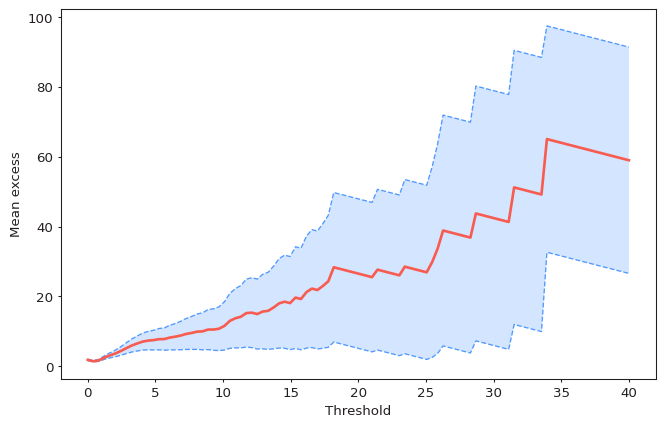

In [166]:
from pyextremes import plot_mean_residual_life

plot_mean_residual_life(losses, thresholds=np.linspace(0, 40, 100))


1983-05-18    0.613936
1983-05-24    0.883640
1983-05-27    1.767280
1983-05-29    5.334240
1983-06-06    1.134004
                ...   
1984-01-08    0.878940
1984-01-09    1.398812
1984-01-10    1.357833
1984-01-14    0.839287
1984-01-15    0.671430
Name: Loss As IF 1980, Length: 113, dtype: float64

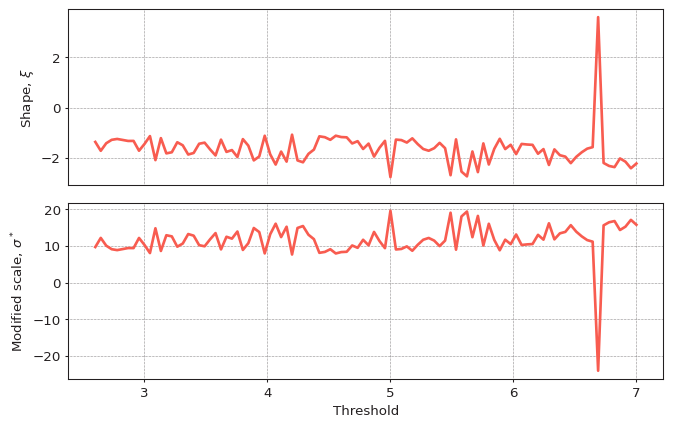

In [168]:
from pyextremes import plot_parameter_stability

losses2 = losses[567:680]
plot_parameter_stability(losses2, thresholds=np.linspace(2.6, 7, 100))
losses2

(<Figure size 768x480 with 1 Axes>,
 <Axes: xlabel='date-time', ylabel='Loss As IF 1980'>)

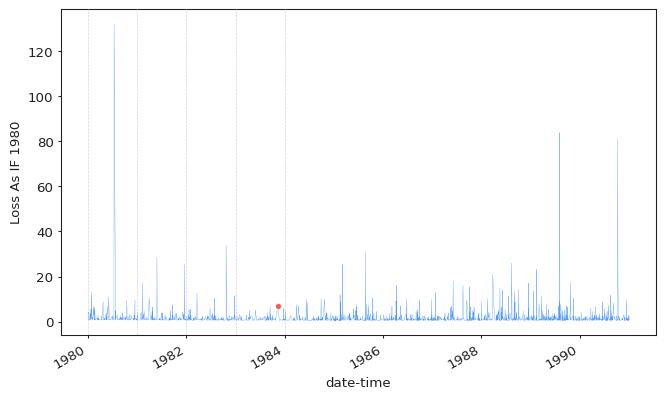

In [172]:
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes

extremes = get_extremes(losses2, "BM")
plot_extremes(
    ts=losses,
    extremes=extremes,
    extremes_method="BM",
    extremes_type="high",
    block_size="365.2425D",
)